# EDA

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import sys

In [2]:
#Reading in the Data
swim1 = pd.read_csv('./swim feb 26.csv')
swim2 = pd.read_csv('./swim feb 27.csv')
run1 = pd.read_csv('./run feb 26.csv')
run2 = pd.read_csv('./run feb 27.csv')

In [3]:
#Renaming columns because they were made numeric during scrape
swim1.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
swim2.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
run1.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)
run2.rename(columns={'0': 'created_utc', '1': 'title', '2': 'selftext', '3': 'subreddit'}, inplace=True)

#Dropping unnecessary index column
swim1.drop(columns=['Unnamed: 0'], inplace=True)
swim2.drop(columns=['Unnamed: 0'], inplace=True)
run1.drop(columns=['Unnamed: 0'], inplace=True)
run2.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
#Checking shape after I dropped the columns
print(swim1.shape, swim2.shape)
print(run1.shape, run2.shape)

(1987, 4) (1935, 4)
(1979, 4) (1934, 4)


In [5]:
#Creating separate, single swim and run dataframes
swim_all = pd.concat([swim1, swim2], axis=0)
run_all = pd.concat([run1, run2], axis=0)
print(swim_all.shape, run_all.shape)

(3922, 4) (3913, 4)


In [6]:
#Dropping rows if they appear as duplicates in 'title' column
swim_all.drop_duplicates(subset=['title'], inplace=True)
run_all.drop_duplicates(subset=['title'], inplace=True)
print(swim_all.shape, run_all.shape)

(2001, 4) (1800, 4)


In [7]:
#Creating one dataframe of all the data
full = pd.concat([swim_all, run_all], axis=0)
full.shape

(3801, 4)

In [8]:
#Checking for NaNs
full.isna().sum()

created_utc       0
title             0
selftext       1054
subreddit         0
dtype: int64

In [9]:
#Checking types
full.dtypes

created_utc    float64
title           object
selftext        object
subreddit       object
dtype: object

In [10]:
#Getting the column names so I can check the balance
full.columns

Index(['created_utc', 'title', 'selftext', 'subreddit'], dtype='object')

In [11]:
#Checking balance --> it's good enough
full.subreddit.value_counts(normalize=True)

subreddit
Swimming    0.52644
running     0.47356
Name: proportion, dtype: float64

In [12]:
#Ordinal mapping my subreddit categories
full['subreddit'] = full['subreddit'].map({'running': 0, 'Swimming': 1})

In [15]:
#Checking it worked
full.sample(10)

,created_utc,title,selftext,subreddit
1983,1.562178e+09,I learned how to swim! :D,I learned how to swim in freestyle! Now I will...,1
206,1.707800e+09,"Achievements for Tuesday, February 13, 2024","Hey runners, it's another day and it is time t...",0
1566,1.495097e+09,I made a fun little video showing off how fast...,NaN,0
492,1.704258e+09,"Achievements for Wednesday, January 03, 2024","Hey runners, it's another day and it is time t...",0
1672,1.539493e+09,In 2 days my team and I will attempt to break ...,"In 2 days, myself and 11 other doctors will st...",0
218,1.708963e+09,How to take care of your hair when swimming?,I have brought ‘Ultra swim’ shampoo and condit...,1
755,1.707170e+09,I record my swims with my Apple Watch but I ne...,I am doing the Alzheimer’s Society’s ‘Swim for...,1
666,1.707421e+09,Is it too late?,I'm a 14 year old that really does have a pass...,1
1822,1.675202e+09,Pretty proud of my 3k swim :). I’m a regular s...,NaN,1
1288,1.599527e+09,Running has helped me heal from my miscarriage,I posted here about a month ago that I was pre...,0


In [16]:
#Joining the title and selftext columns into a single column 'all_text'
# Selftext has a ton of NaNs as seen above
full['all_text'] = full['title'] + ' ' + full['selftext'].fillna('')

In [17]:
#Transforming the 'created_utc' to more interpretable datetime to see if that has a correlation to sentiment later
full['datetime'] = full['created_utc'].apply(lambda x: pd.to_datetime(x, unit='s'))

In [19]:
#I noticed later on in the EDA that the word 'collections' kept showing up, so I came back to the top to see why
full[full['all_text'].str.contains('collections', case=False)]

,created_utc,title,selftext,subreddit,all_text,datetime
84,1.708706e+09,Rash Guard for casual swim older person - long...,Need advice looking to buy a rash guard (not s...,1,Rash Guard for casual swim older person - long...,2024-02-23 16:36:06
2,1.708924e+09,"Official Q&A for Monday, February 26, 2024","With over 2,900,000 subscribers, there are a l...",0,"Official Q&A for Monday, February 26, 2024 Wit...",2024-02-26 05:01:19
9,1.708837e+09,"Official Q&A for Sunday, February 25, 2024","With over 2,900,000 subscribers, there are a l...",0,"Official Q&A for Sunday, February 25, 2024 Wit...",2024-02-25 05:01:08
17,1.708751e+09,"Official Q&A for Saturday, February 24, 2024","With over 2,900,000 subscribers, there are a l...",0,"Official Q&A for Saturday, February 24, 2024 W...",2024-02-24 05:01:08
25,1.708664e+09,"Official Q&A for Friday, February 23, 2024","With over 2,900,000 subscribers, there are a l...",0,"Official Q&A for Friday, February 23, 2024 Wit...",2024-02-23 05:01:09
...,...,...,...,...,...,...
1067,1.699157e+09,"Official Q&A for Sunday, November 05, 2023","With over 2,675,000 subscribers, there are a l...",0,"Official Q&A for Sunday, November 05, 2023 Wit...",2023-11-05 04:01:11
1078,1.699070e+09,"Official Q&A for Saturday, November 04, 2023","With over 2,675,000 subscribers, there are a l...",0,"Official Q&A for Saturday, November 04, 2023 W...",2023-11-04 04:01:11
1088,1.698984e+09,"Official Q&A for Friday, November 03, 2023","With over 2,675,000 subscribers, there are a l...",0,"Official Q&A for Friday, November 03, 2023 Wit...",2023-11-03 04:01:09
1454,1.579739e+09,My Nintendo Switch treadmill setup; how I play...,I posted a comment on this post [https://www....,0,My Nintendo Switch treadmill setup; how I play...,2020-01-23 00:15:18


In [20]:
#There seems to be a bunch of automatic/standardized posts that are just creating a place for people to ask questions
# I will drop these
full = full[~full['all_text'].str.contains('Official Q&A for', case=False)]

In [21]:
#Creating a post_word_count and title_word_count column to see if there is a correlation between subreddit and word count
word_count = full['all_text'].str.split()
title_word_count = full['title'].str.split()
full['post_word_count'] = [len(i) for i in word_count]
full['title_word_count'] = [len(i) for i in title_word_count]
full = full.drop(columns=['created_utc', 'title', 'selftext'])

In [22]:
#Assigning X y so I can do Sentiment Analysis
X = full['all_text']
y = full['subreddit']

#TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2024)

In [23]:
#Adding stopwords to my nltk english stopwords bc they keep showing up
sw = stopwords.words('english') + ['https', 'http', 'www', 'wiki', 'reddit', 'com', 'faq']

#Instantiating CountVectorizer
cvec = CountVectorizer(stop_words=sw)

#Fitting to corpus
cvec.fit(X_train)

#Transforming
X_train_cv = cvec.transform(X_train)
X_test_cv = cvec.transform(X_test)

In [24]:
X_train_cv.shape

(2763, 17777)

In [25]:
#Making X_train_cvec into a dataframe
X_train_df = pd.DataFrame(
    X_train_cv.toarray(), 
    columns=cvec.get_feature_names_out()
)

#Checking it worked
X_train_df.head()

,00,000,0001,000kms,000m,006151,00am,00min,00minutes,00pm,...,zt87htemx,zucchini,zumba,zwift,zwinslett,zygo,zzmcjjt,zürich,être,ön
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Getting Most Common Words

In [26]:
# Top words by frequency for full dataframe
top_full = X_train_df.sum().sort_values(ascending=False).head(25)
top_full

running     3118
run         2571
time        2194
race        2021
like        1724
marathon    1426
first       1343
get         1330
miles       1264
training    1239
mile        1215
would       1108
one         1107
swimming    1051
really      1038
back         998
started      990
day          976
pace         953
week         929
10           923
year         885
got          863
swim         855
half         843
dtype: int64

In [27]:
#Realized I should maybe try lemmatizing for better sentiment analysis, so came back to create lemmatizer
def lemmatize_reddit(doc):
    split_doc = doc.split()
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(i) for i in split_doc])     

In [29]:
#Creating a series of just r/Swimming rows
swim_mask = full[full['subreddit'] == 1]
swim_lem = swim_mask['all_text']

#Instantiating CountVectorizer with lemmatizer this time 
cvec_lem = CountVectorizer(stop_words=sw, ngram_range=(1,2), preprocessor=lemmatize_reddit)

#Fitting the data
cvec_lem.fit(swim_lem)

#Transforming the data
swimlem_cv = cvec_lem.transform(swim_lem)
swimlem_cv_df = pd.DataFrame(
    swimlem_cv.todense(),
    columns=cvec_lem.get_feature_names_out()
)

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


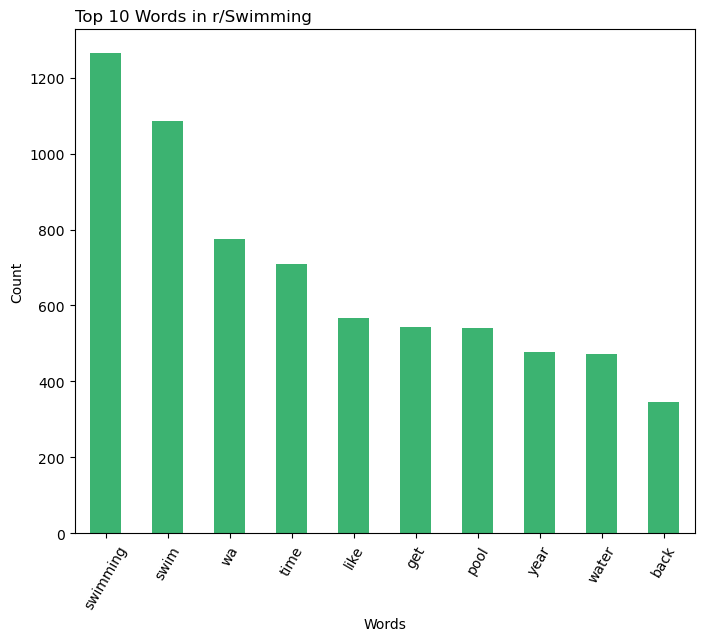

In [195]:
#Plotting the top 10 words of r/Swimming

plt.figure(figsize=(8, 8))


swimlem_cv_df.sum().sort_values(ascending=False).head(10).plot(kind='bar', color='mediumseagreen')
plt.title('Top 10 Words in r/Swimming', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Top_10_Words_rSwim.png')

**THOUGHTS**: These seem to make sense, though they're difficult to interpret or make sense of them since they have no context.

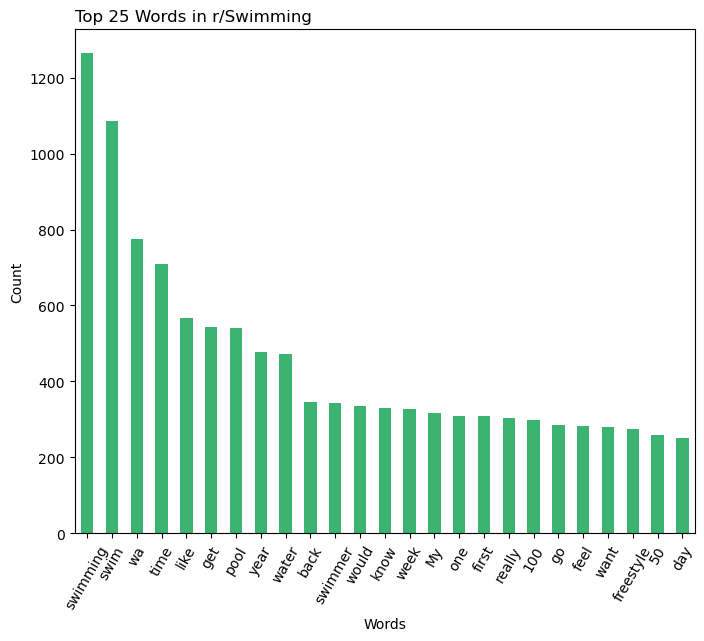

In [196]:
#Looking at the top 25 words of r/Swimming

plt.figure(figsize=(8, 8))

swimlem_cv_df.sum().sort_values(ascending=False).head(25).plot(kind='bar', color='mediumseagreen')
plt.title('Top 25 Words in r/Swimming', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Top_25_Words_rSwim.png')

**THOUGHTS**: Basically the same thoughts as above, this is just a more extensive list. 

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


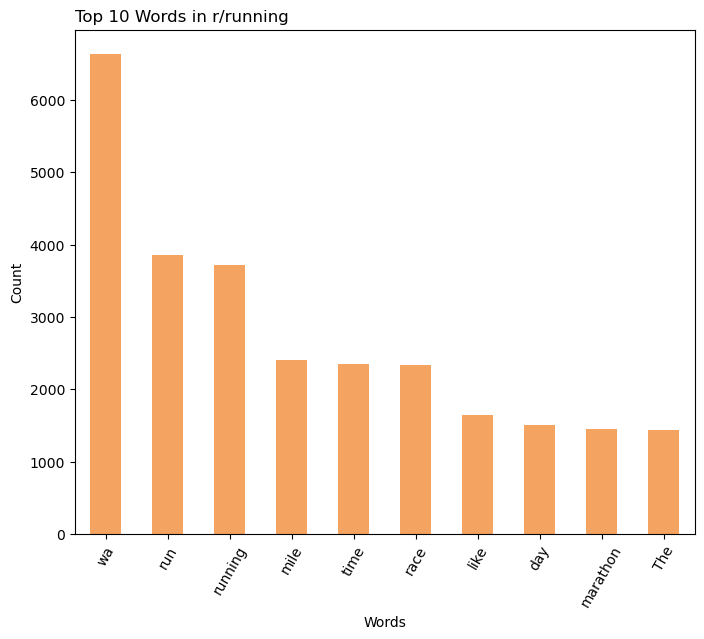

In [197]:
#Plotting the top 10 words for r/running
plt.figure(figsize=(8, 8))

#Creating a series of all_text of just the rows of from r/running
run_mask = full[full['subreddit'] == 0]
run_lem = run_mask['all_text']


#Fitting it to the CountVectorizer from above
cvec_lem.fit(run_lem)

#Transforming
runlem_cv = cvec_lem.transform(run_lem)
runlem_cv_df = pd.DataFrame(
    runlem_cv.todense(),
    columns=cvec_lem.get_feature_names_out()
)

#Plotting
runlem_cv_df.sum().sort_values(ascending=False).head(10).plot(kind='bar', color='sandybrown')
plt.title('Top 10 Words in r/running (lemmatized)', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Top_10_Words_rRun.png')

**THOUGHTS**: Same deal as swimming. This is tough to interpret since there is no context for any. I can say these words look right though.
Also, 'wa' seems to appear in both. 

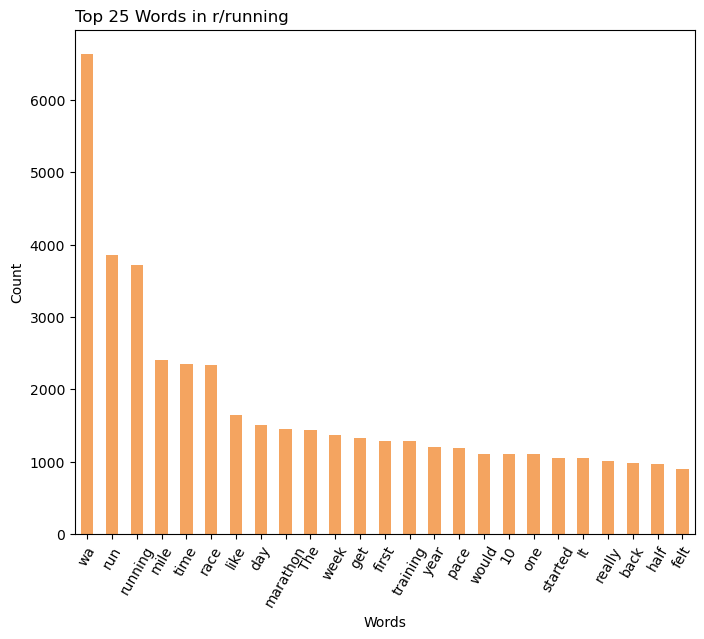

In [199]:
#Plotting top 25 words in r/Running

plt.figure(figsize=(8, 8))

runlem_cv_df.sum().sort_values(ascending=False).head(25).plot(kind='bar', color='sandybrown')
plt.title('Top 25 Words in r/running (lemmatized)', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Top_25_Words_rRun.png')

**THOUGHTS**: Same deal as above.

# Bi_Grams & Tri_Grams

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


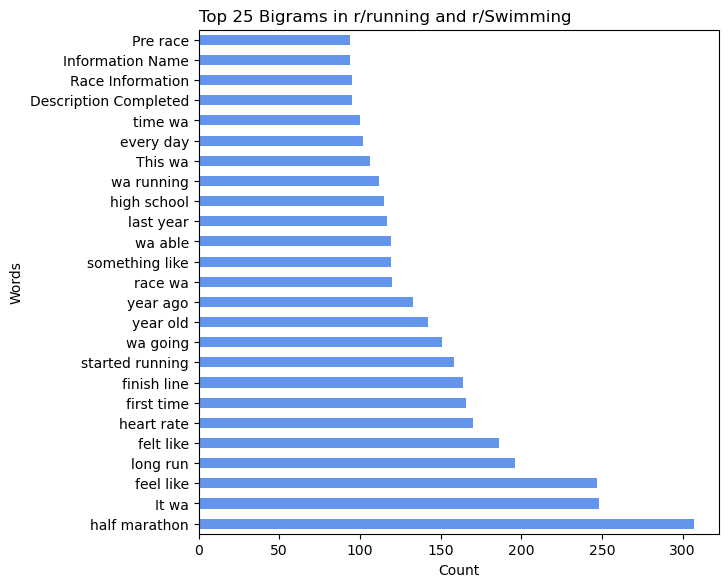

In [202]:
#Getting all top Bigrams
plt.figure(figsize=(8, 8))


#Instantiating CountVectorizer for bigrams
bi_cvec_lem = CountVectorizer(stop_words=sw, ngram_range=(2,2), preprocessor=lemmatize_reddit)

#Fitting to corpus
bi_cvec_lem.fit(X_train)

#Transforming
Xbi_train_cv_lem = bi_cvec_lem.transform(X_train)
Xbi_test_cv_lem = bi_cvec_lem.transform(X_test)

#Making X_train_cvec into a dataframe
Xbi_train_df_lem = pd.DataFrame(
    Xbi_train_cv_lem.toarray(), 
    columns=bi_cvec_lem.get_feature_names_out()
)

#Plotting
Xbi_train_df_lem.sum().sort_values(ascending=False).head(25).plot(kind='barh', color='cornflowerblue')
plt.title('Top 25 Bigrams in r/running and r/Swimming (lemmatized)', loc='left');
plt.xlabel('Count')
plt.ylabel('Words')
plt.subplots_adjust(left=0.25, bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Bi_25_Full.png')

**THOUGHTS**: Can see here that 'wa' is most likely supposed to be 'was' and is a typo

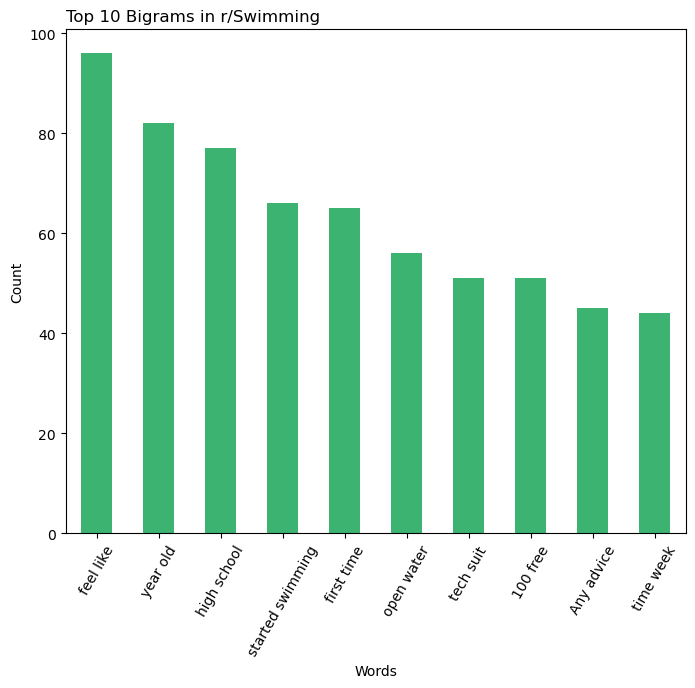

In [191]:
#Getting top 10 r/Swimming Bigrams
plt.figure(figsize=(8, 8))

#bi_grams for swimmer subreddit with lemmatizer
bi_cvec_lem.fit(swim_bi)

#Transforming
swim_bi_cv_lem = bi_cvec_lem.transform(swim_bi)
swim_bi_df_lem = pd.DataFrame(
    swim_bi_cv_lem.todense(),
    columns=bi_cvec_lem.get_feature_names_out()
)


#Plotting the bigrams
swim_bi_df_lem.sum().sort_values(ascending=False).head(10).plot(kind='bar', color='mediumseagreen', fontsize=10)


plt.title('Top 10 Bigrams in r/Swimming (lemmatized)', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
plt.savefig('./Images/Bi_10_Swim.png')

**THOUGHTS**: Can see here that swimming is a bit more technical and question/advice oriented. More focused on improvement with "started swimming", "year old", and "first time".

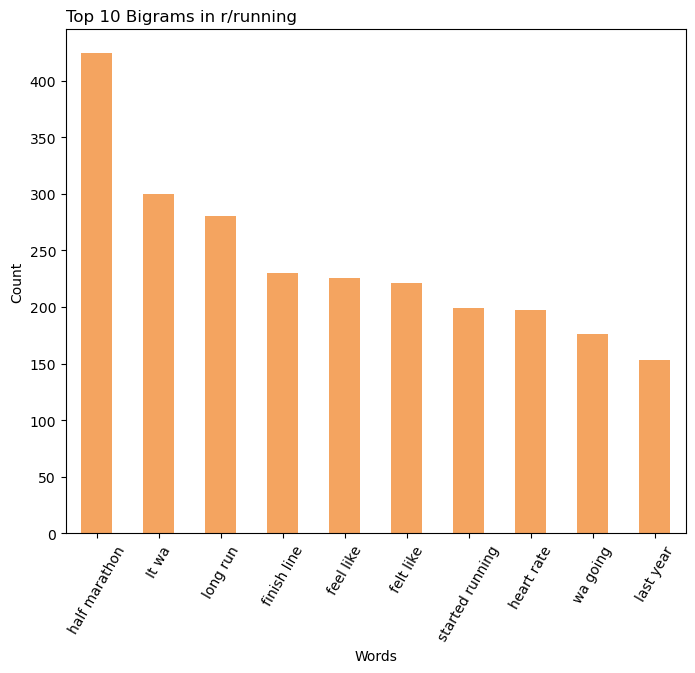

In [203]:
#Getting top r/running bigrams

plt.figure(figsize=(8, 8))

#Top bi_grams for running subreddit with lemmatizer
run_bi = run_mask['all_text']

#Fitting the data 
bi_cvec_lem.fit(run_bi)

#Transforming
run_bi_cv_lem = bi_cvec_lem.transform(run_bi)
run_bi_df_lem = pd.DataFrame(
    run_bi_cv_lem.todense(),
    columns=bi_cvec_lem.get_feature_names_out()
)

#Plotting the data
run_bi_df_lem.sum().sort_values(ascending=False).head(10).plot(kind='bar', color='sandybrown')
plt.title('Top 10 Bigrams in r/running (lemmatized)', loc='left');
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
plt.savefig('./Images/Bi_10_Run.png')

**THOUGHTS**: Can see here words like "feel like" and "felt like" and "half marathon" which are emotional and accomplishment focused words. 

/Users/dillondiatlo/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'drive', 'ha', 'wa'] not in stop_words.
  warnings.warn(


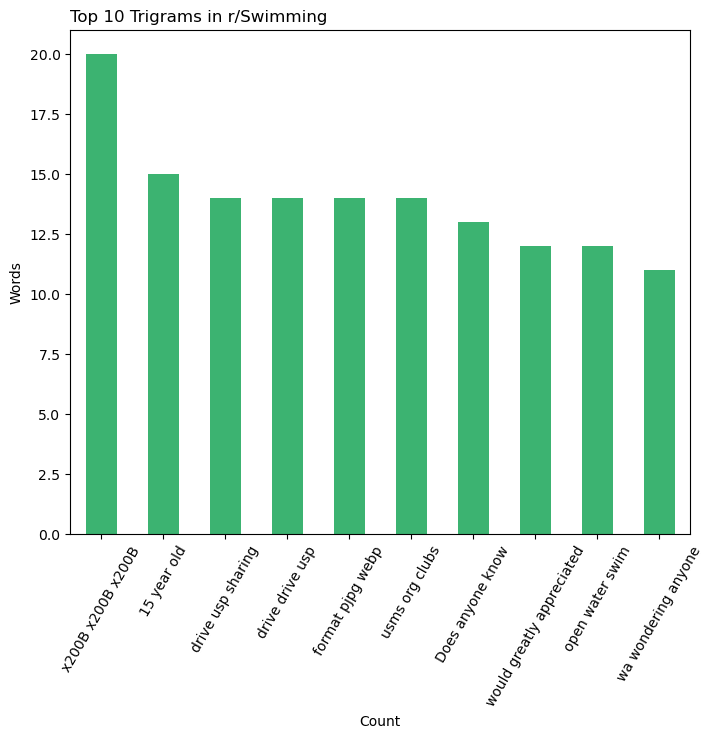

In [206]:
#Getting Trigramas for r/Swimming and hoping for better understanding of sentiment
plt.figure(figsize=(8, 8))

#Top tri_grams for swimmer subreddit
swim_tri = swim_mask['all_text']

#Instantiating CountVectorizer for trigrams
tri_cvec_lem = CountVectorizer(stop_words=sw2, ngram_range=(3,3), preprocessor=lemmatize_reddit)
tri_cvec_lem.fit(swim_tri)

#Transforming
swim_tri_cv_lem = tri_cvec_lem.transform(swim_tri)
swim_tri_df_lem = pd.DataFrame(
    swim_tri_cv_lem.todense(),
    columns=tri_cvec_lem.get_feature_names_out()
)

#Plotting Trigrams
swim_tri_df_lem.sum().sort_values(ascending=False).head(10).plot(kind='bar', color='mediumseagreen')
plt.title('Top 10 Trigrams in r/Swimming (lemmatized)', loc='left');
plt.xlabel('Count')
plt.ylabel('Words')
plt.xticks(rotation = 60)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout;
#plt.savefig('./Images/Tri_10_Swim.png')

**THOUGHTS**: Swimming seems to be more question and improvement focused, though it definitely needs more data cleaning.

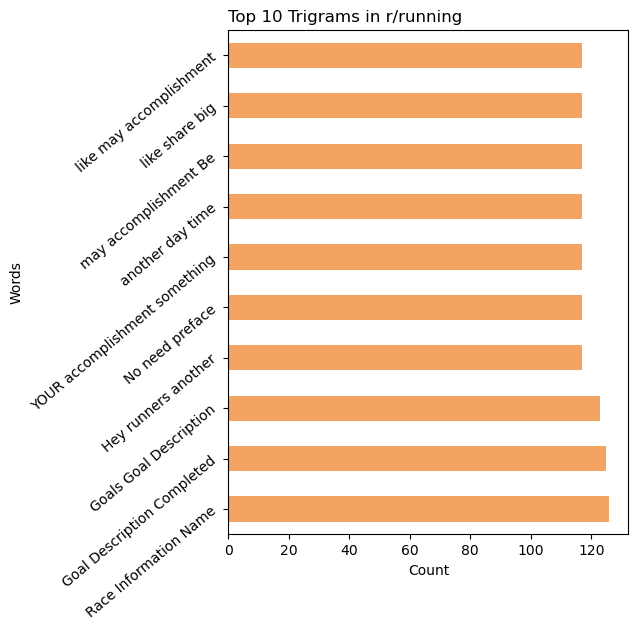

In [211]:
#Getting top trigrams from r/running
plt.figure(figsize=(8, 8))

#Top tri_grams for running subreddit with lemmatizer
tri_cvec_lem.fit(run_tri)

#Transforming
run_tri_cv_lem = tri_cvec_lem.transform(run_tri)
run_tri_df_lem = pd.DataFrame(
    run_tri_cv_lem.todense(),
    columns=tri_cvec_lem.get_feature_names_out()
)

#Plotting the trigrams
run_tri_df_lem.sum().sort_values(ascending=False).head(10).plot(kind='barh', color='sandybrown')
plt.title('Top 10 Trigrams in r/running', loc='left');
plt.xlabel('Count')
plt.ylabel('Words')
plt.yticks(rotation = 40)
plt.subplots_adjust(left=0.4, bottom=0.25)
plt.tight_layout;
plt.savefig('./Images/Tri_10_Run.png')

**THOUGHTS**: r/running posts are way more accomplishment and goal focused

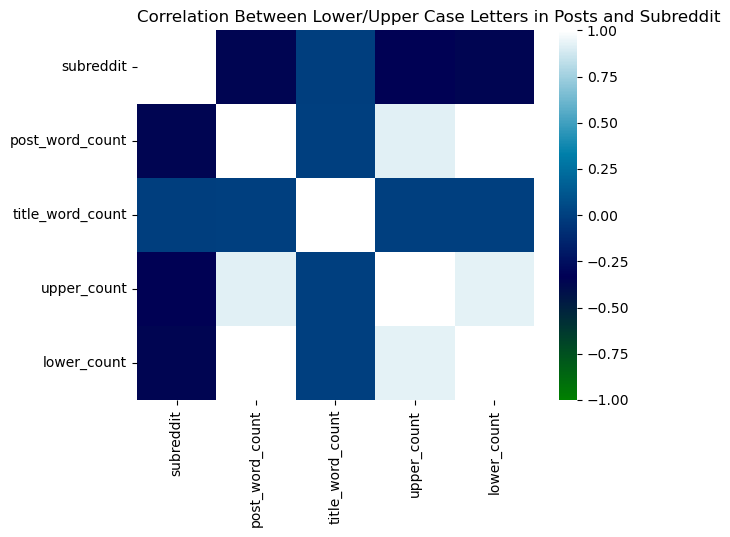

In [44]:
#Seeing if there is correlation between casing in letters for later on
full['upper_count'] = full['all_text'].str.count(r'[A-Z]')
full['lower_count'] = full['all_text'].str.count(r'[a-z]')
sns.heatmap(full.corr(numeric_only=True), vmin=-1, vmax=1, cmap='ocean');
plt.title('Correlation Between Lower/Upper Case Letters in Posts and Subreddit', loc='left');

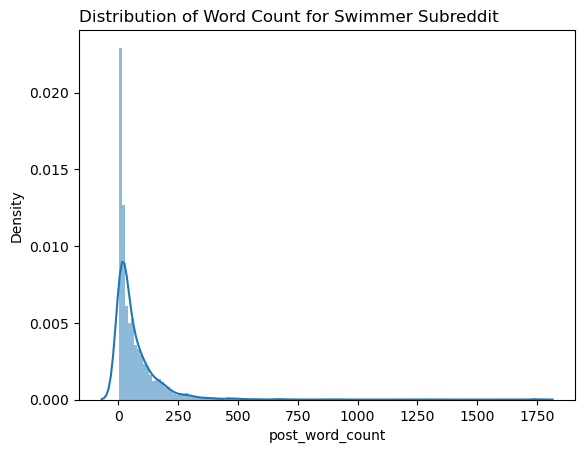

In [45]:
#Looking a distribution of word count to see if it's important for r/Swimming
sns.histplot(swim_mask['post_word_count'], thresh=4, linewidth=0, kde=True, stat='density', kde_kws=dict(cut=3))
plt.title('Distribution of Word Count for Swimmer Subreddit', loc='left');

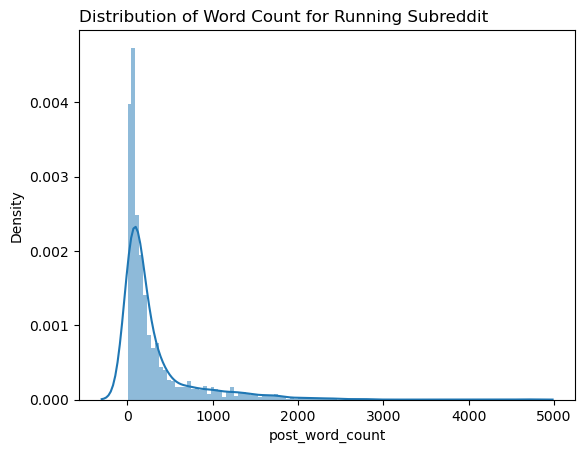

In [46]:
#Looking a distribution of word count to see if it's important for r/running
sns.histplot(run_mask['post_word_count'], thresh=4, linewidth=0, kde=True, stat='density', kde_kws=dict(cut=3))
plt.title('Distribution of Word Count for Running Subreddit', loc='left');

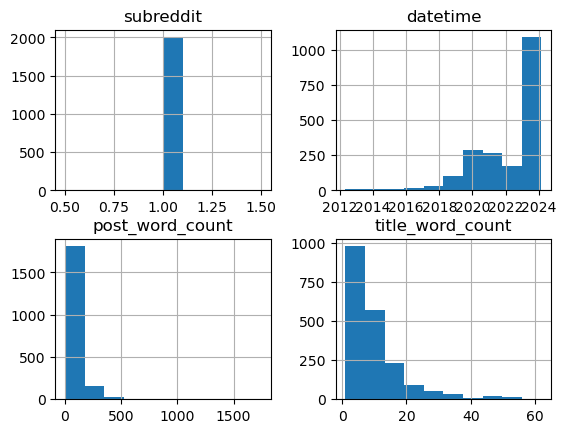

In [47]:
#Checking out swimming histograms to see anything weird. Have some left skewed and right skewed graphs here. 
swim_mask.hist();

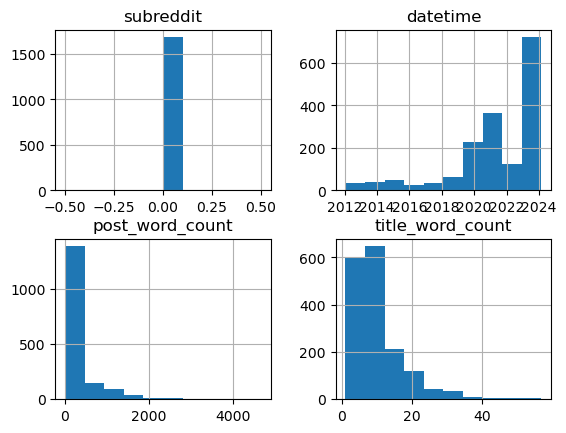

In [48]:
#Checking out running histograms to see anything weird. Have some left skewed and right skewed graphs here like swimming.
run_mask.hist();

In [49]:
#Creating a sentiment analyzer to, well, analyze sentiment
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(posts):
    scores = analyzer.polarity_scores(posts)
    return scores['compound']

#Creating a column for the sentiment to see correlation
full['sentiment'] = full['all_text'].apply(lambda x: get_sentiment(x))

In [50]:
#Looking at the quick stats for full dataframe and reordering the dataframe columns because it's frustrating me in the order it was in
full.head()
full = full.reindex(columns=['datetime', 'all_text', 'subreddit', 'sentiment', 'post_word_count', 'title_word_count', 'upper_count', 'lower_count'])
full.describe()

,datetime,subreddit,sentiment,post_word_count,title_word_count,upper_count,lower_count
count,3684,3684.000000,3684.000000,3684.000000,3684.000000,3684.000000,3684.000000
mean,2021-12-24 05:35:23.820846848,0.543160,0.420479,177.709826,10.381107,26.466069,696.960098
min,2012-01-13 14:00:03,0.000000,-0.997700,1.000000,1.000000,0.000000,0.000000
25%,2020-07-08 09:37:17.500000,0.000000,0.000000,21.000000,5.000000,4.000000,82.000000
50%,2022-10-15 13:56:39,1.000000,0.632200,67.000000,8.000000,11.000000,269.000000
75%,2024-02-01 22:37:07.750000128,1.000000,0.918600,170.000000,13.000000,24.000000,668.000000
max,2024-02-27 19:58:48,1.000000,0.999900,4680.000000,62.000000,970.000000,18561.000000
std,NaN,0.498201,0.571302,332.893672,8.234859,51.474645,1282.089533


In [51]:
#Looking at quick stats for r/Swimming data
swim_mask = full[full['subreddit'] == 1]
swim_mask.describe()

,datetime,subreddit,sentiment,post_word_count,title_word_count,upper_count,lower_count
count,2001,2001.0,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,2022-05-19 12:39:38.177911296,1.0,0.309921,70.252374,10.271364,10.490755,279.373813
min,2012-05-03 18:32:30,1.0,-0.996400,1.000000,1.000000,0.000000,0.000000
25%,2020-10-03 17:32:07,1.0,0.000000,12.000000,5.000000,2.000000,47.000000
50%,2024-01-24 01:41:14,1.0,0.401900,34.000000,8.000000,6.000000,135.000000
75%,2024-02-11 15:04:45,1.0,0.789500,92.000000,13.000000,13.000000,363.000000
max,2024-02-27 19:58:48,1.0,0.999700,1745.000000,62.000000,354.000000,7937.000000
std,NaN,0.0,0.524027,108.687464,8.784237,16.590480,459.122780


In [95]:
#Looking at quick stats for r/running data
run_mask = full[full['subreddit'] == 0]
run_mask.describe()

,datetime,subreddit,sentiment,post_word_count,title_word_count,upper_count,lower_count
count,1683,1683.0,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000
mean,2021-07-03 07:06:30.387403264,0.0,0.551926,305.471182,10.511586,45.459893,1193.448604
min,2012-01-13 14:00:03,0.0,-0.997700,2.000000,1.000000,0.000000,8.000000
25%,2020-05-11 21:18:24.500000,0.0,0.308500,52.000000,6.000000,10.000000,222.000000
50%,2021-10-03 16:47:29,0.0,0.837900,132.000000,8.000000,19.000000,535.000000
75%,2023-12-08 01:18:53,0.0,0.980000,329.500000,13.000000,47.000000,1296.500000
max,2024-02-27 16:56:54,0.0,0.999900,4680.000000,57.000000,970.000000,18561.000000
std,NaN,0.0,0.596926,445.575544,7.530221,69.353598,1701.325819


**THOUGHTS**: Nothing looks too strange in either of running or swimming quick stats. I will say I am surprised to see that the overall mean sentiment is hire for r/running.

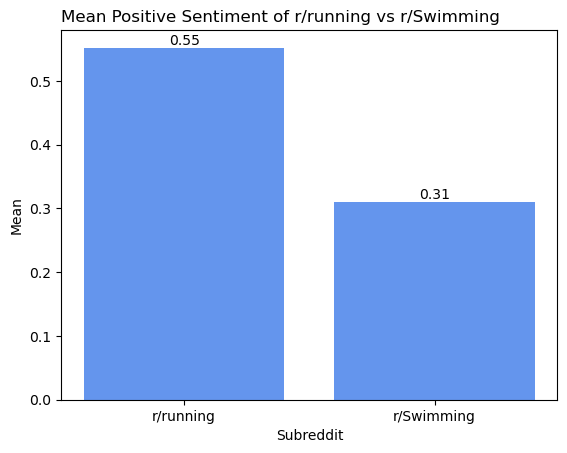

In [161]:
#Plotting the sentiment mean of the two subreddits to compare
swim_mean = swim_mask['sentiment'].mean()
run_mean = run_mask['sentiment'].mean()
means = [run_mean, swim_mean]


plt.bar(['r/running', 'r/Swimming'], [run_mean, swim_mean], color='cornflowerblue')

for i, mean in enumerate(means):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom')

plt.ylabel('Mean')
plt.title('Mean Positive Sentiment of r/running vs r/Swimming', loc='left');
plt.xlabel('Subreddit')
plt.savefig('./Images/Mean_Sent_Compare.png')

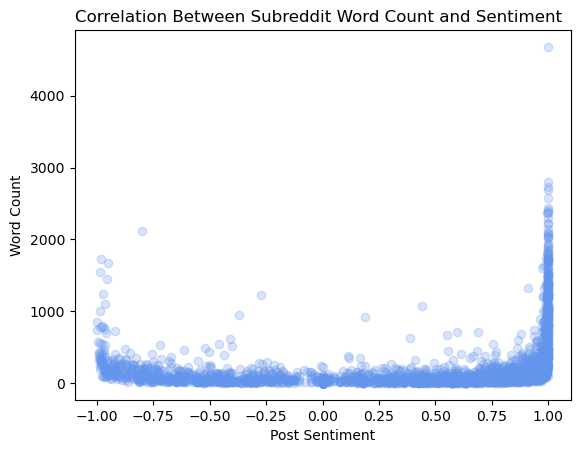

In [212]:
#Let's find some more correlations... Plotting word count vs. Sentiment for full dataframe

plt.scatter(full['sentiment'], full['post_word_count'], alpha=1/4, color='cornflowerblue');
plt.xlabel('Post Sentiment')
plt.ylabel('Word Count')
plt.title('Correlation Between Subreddit Word Count and Sentiment', loc='left');

**THOUGHTS**: The more positive sentiment the post, the more words the post has...

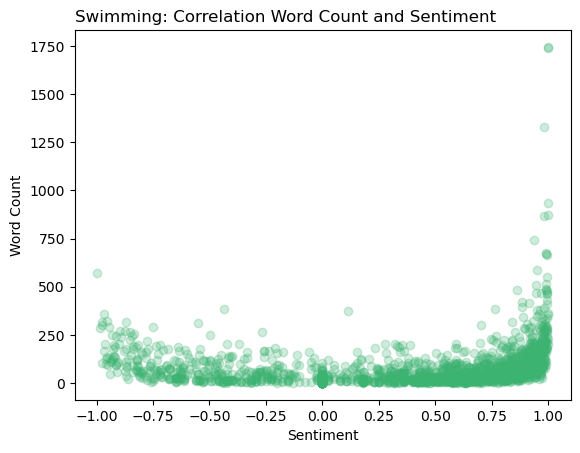

In [162]:
#Checking for sentiment and word count in swimming
plt.scatter(swim_mask['sentiment'], swim_mask['post_word_count'], alpha=1/4, color='mediumseagreen');
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.title('Swimming: Correlation Word Count and Sentiment', loc='left');
plt.savefig('./Images/Swim_WordCount_Sentiment.png')

**THOUGHTS**: There is a heavy clustering of high word count for positive correlation here

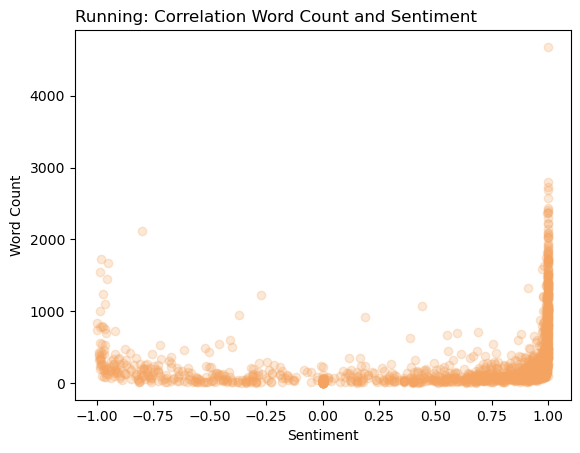

In [163]:
#Plotting correlation of word count and sentiment for r/running
plt.scatter(run_mask['sentiment'], run_mask['post_word_count'], alpha=1/4, color='sandybrown');
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.title('Running: Correlation Word Count and Sentiment', loc='left');
plt.savefig('./Images/Run_WordCount_Sentiment.png')

**THOUGHTS**: There is a heavy clustering of high word count for positive correlation here

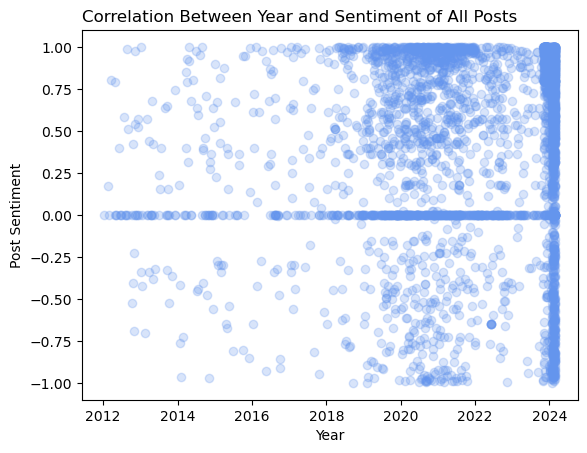

In [215]:
#Plotting correlation of date and sentiment
plt.scatter(full['datetime'], full['sentiment'], alpha=1/4, color='cornflowerblue');
plt.xlabel('Year')
plt.ylabel('Post Sentiment')
plt.title('Correlation Between Year and Sentiment of All Posts', loc='left');

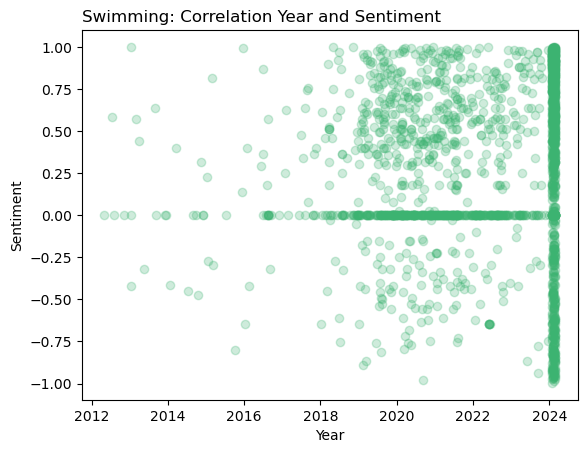

In [167]:
#Plotting correlation of r/Swimming post date and sentiment
plt.scatter(swim_mask['datetime'], swim_mask['sentiment'], alpha=1/4, color='mediumseagreen');
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('Swimming: Correlation Year and Sentiment', loc='left');
plt.savefig('./Images/Swim_Year_Sentiment.png')

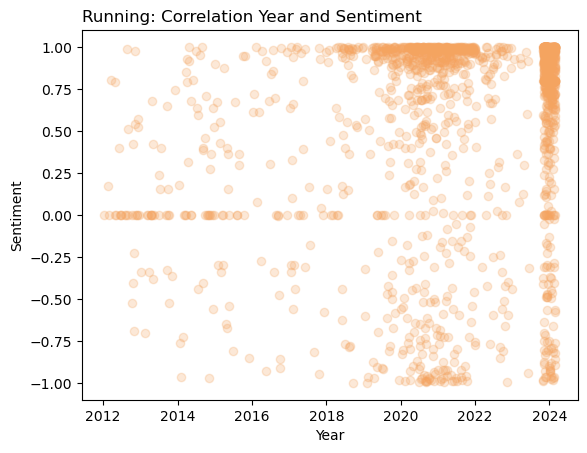

In [166]:
#Plotting correlation between r/running post date and sentiment of post
plt.scatter(run_mask['datetime'], run_mask['sentiment'], alpha=1/4, color='sandybrown');
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('Running: Correlation Year and Sentiment', loc='left');
plt.savefig('./Images/Run_Year_Sentiment.png')

**THOUGHTS ON DATE AND SENTIMENT**: This is super interesting. It seems as if runner posts have a higher post sentiment in general and less neutral posts. Meanwhile, swimmers have more neutral post sentiment consistently, with a little clustering of positive sentiment, but a real serious even distribution in 2024.

Another thing is the cluster of positive posts for runners between 2020 and 2022. This is covid time, which is a time when a lot of people took up running as they couldn't exercise at gyms or in enclosed spaces like pools.

In [216]:
#Calculating percentage of overall positive r/Swimming sentiment posts
swim_positive = swim_mask[swim_mask['sentiment'] >= 0.0]
print(len(swim_positive['sentiment']))
print(len(swim_mask['sentiment']))

(1641/2001)*100 #82% positive

1641
2001


82.00899550224887

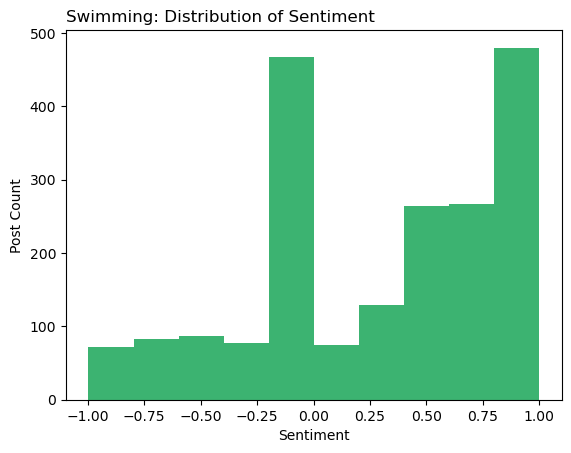

In [168]:
#Plotting the distribution of sentiment in r/Swimming
plt.hist(swim_mask['sentiment'], color='mediumseagreen');
plt.xlabel('Sentiment')
plt.ylabel('Post Count')
plt.title('Swimming: Distribution of Sentiment', loc='left');
plt.savefig('./Images/Swim_DistSentiment.png')

**THOUGHTS**: There are 2 spikes in distribution here, which might infer two different types of r/Swimming posters...

In [217]:
##Calculating percentage of overall positive r/running sentiment posts
run_positive = run_mask[run_mask['sentiment'] >= 0.0]
print(len(run_positive['sentiment']))
print(len(run_mask['sentiment']))

(1407/1683)*100 #83.6% positive

1407
1683


83.60071301247773

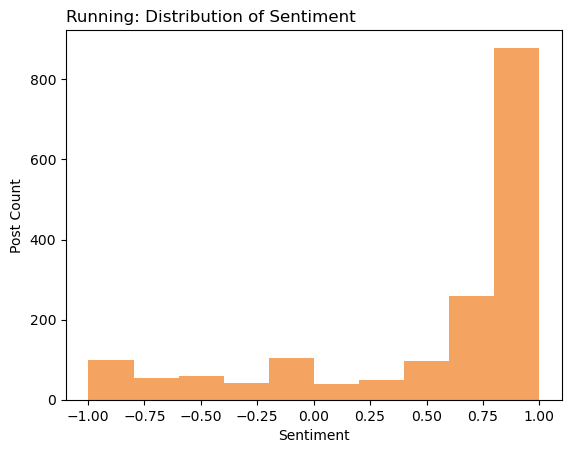

In [169]:
#Plotting the distribution of sentiment in r/running
plt.hist(run_mask['sentiment'], color='sandybrown');
plt.xlabel('Sentiment')
plt.ylabel('Post Count')
plt.title('Running: Distribution of Sentiment', loc='left');
plt.savefig('./Images/Run_DistSentiment.png')

**THOUGHTS**: Running has a left skewed distribution. This means that most posts are higher sentiment.

In [59]:
#Exporting the new, cleaned data frame to use in the Modeling notebook
full.to_csv('./Data/full.csv')